
## Multivariate time series prediction using Transformer


### In this document we explain how a Transformer encoder network is supposed to process information. 
<i> Note: We use PatchTST which is a popular time series forecasting model that uses a Transformer Encoder to make predictions</i>

The multi-head attention functionality.

Let's suppose the input to the model is a sequence given by
$$[x_1, x_2, x_3, ..., x_{12}]$$ (these are tokens input to the model)

We first reshape it into a following matrix (called embeddings) of some patch size let's say 4.
$$ Input (I) = \begin{bmatrix}
x_1 & x_2 & x_3 & x_4 \\
x_5 & x_6 & x_7 & x_8 \\
x_9 & x_{10} & x_{11} & x_{12} \\  
\end{bmatrix}^T = 
\begin{bmatrix}
x_1 & x_5 & x_9  \\
x_2 & x_6 & x_{10} \\
x_3 & x_7 & x_{11} \\
x_4 & x_8 & x_{12}
\end{bmatrix}  (4 \times 3)
$$

We use a fc layer of shape let's name it $( 3 \times 10)$, (this is called enriching embeddings with the positional encodings to retain the sequence order information), the output of this process is a $(4 \times 10)$ matrix. Let's denote the output matrix by say $x_d$

Now the output of the FC layer is passed through the multi-head attention block.
The number of heads can be any number you can define. I will explain what happens in one of those heads. 

Each head has three matrices, let's name them $W_Q, W_K, W_V.$
We compute the following.
$$ Q_h = x_d \times W_Q $$
$$ K_h = x_d \times W_K $$
$$ V_h = x_d \times W_V $$

Note that the no. of columns of Q, K, V is equal to some value let's say $d_k$ (user-defined)

The attention value for a head is calculated as 
$$
O_h = softmax\left( \frac{Q_h K_h^T}{\sqrt{d_k}} \right) V_h
$$

Let's suppose the output $O_h$ has dimensions $(4 \times 10)$

In general there are multiple heads, so we have output of attention heads as $O_1, O_2, ..., O_h$. \
The attention heads are concatenated to get multi head attention
$$O_{multi-head} = Concat(O_1, O_2, O_3, ... , O_h)$$

A weight matrix $W^o$ (Output Projection Matrix) is used to bring back the $O_{multi-head}$ to the shape of $x_d$.
And we compute

$O' = O_{multi-head} \times W^o$ \
and we calculate residuals as \
$O_{residual} = O' + x_d$

This $O_{residual}$ is the input to the feedforward network to get the required output.



In [1]:
import torch
import numpy as np
import math

import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
path = '../dataset/final_data.csv'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cuda


Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the Pytorch Dataset class.  
- We need to define \_\_init__() function which can be used for loading data from the file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [4]:
class RiverData(torch.utils.data.Dataset):
    
    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()
        

    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)
    

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature, label) 

### Normalize the data

In [5]:
df = pd.read_csv(path)
raw_df = df.drop('DATE', axis=1, inplace=False)
scaler = MinMaxScaler()

# Apply the transformations
df_scaled = scaler.fit_transform(raw_df)

df_scaled = pd.DataFrame(df_scaled, columns=raw_df.columns)
df_scaled['DATE'] = df['DATE']
df = df_scaled

Some advanced Python syntax has been used here. \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [6]:

train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 13
pred_len = 1
num_features = 7
num_layers = 1


common_args = ['gauge_height', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)


In [7]:
# Important parameters

BATCH_SIZE = 512 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load
learning_rate = 1e-3


In [8]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)


### Positional Encoding

The transformer implementation in pytorch doesn't implement the positional encoding which is an essential part of the transforemer model.

1. This code implements sinusoidal positional encoding, transforming absolute positions into a d-dimensional vector space to provide sequence order information to a Transformer model, which lacks inherent recurrence.

2. The encoding utilizes sine and cosine functions with frequencies varying geometrically across the embedding dimensions, allowing the model to learn relative positional relationships.

3. By adding this positional encoding directly to the input embeddings, the model can differentiate tokens based on their position in the sequence during self-attention calculations.

4. The exponential scaling within the div_term ensures that wavelengths increase across dimensions, facilitating the encoding of both short and long-range dependencies.

5. Registering Xp as a buffer makes the precomputed positional encodings part of the model state, ensuring consistent encoding across different inputs and facilitating efficient batched operations.

In [9]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, pos_enc_dropout, max_len=5000):
        super().__init__();
        self.dropout = torch.nn.Dropout(p=pos_enc_dropout)

        Xp = torch.zeros(max_len, d_model) # max_len x d_model
        position = torch.arange(0, max_len).unsqueeze(1) # max_len x 1
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(100000.0) / d_model)) #length: d_model/2

        #Applying sine to even indices in the array; 2i
        Xp[:, 0::2] = torch.sin(position.float() * div_term)

        #Applying cosine to odd indices in the array; 2i + 1
        Xp[:, 1::2] = torch.cos(position.float() * div_term)

        Xp = Xp.unsqueeze(1)
        self.register_buffer('Xp', Xp)

    def forward(self, x):
        x  = x + self.Xp[:x.size(0)]
        return self.dropout(x)




### Here we define our PyTorch model.

BasicTransformerNetwork is the model class, it extends the Module class provided by Pytorch. 
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forwared pass computation occurs



In [10]:
class BasicTransformerNetwork(torch.nn.Module):
    
    def __init__(self, seq_len, pred_len, enc_layer_dropout, pos_enc_dropout):
        # call the constructor of the base class
        super().__init__()
        self.model_type = 'Transformer'
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features

        # I don't think the embedding size should be this big. We will see.
        self.embedding_size = 128 #The features are converted to 512 embeddings
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoding(self.embedding_size, pos_enc_dropout, 10000)
        
        
        self.encLayer = torch.nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=8, 
                                                 dim_feedforward=256, dropout=enc_layer_dropout, activation="relu", 
                                                 layer_norm_eps=1e-05, batch_first=True, norm_first=False, bias=True, 
                                                 device=None, dtype=None)
        
        self.transformerEnc = torch.nn.TransformerEncoder(self.encLayer, num_layers=self.num_layers)

        self.input_fc = torch.nn.Linear(self.num_features, self.embedding_size)
        self.relu = torch.nn.ReLU()
        
        self.output_fc1 = torch.nn.Linear(self.embedding_size, self.pred_len)
        self.output_fc2 = torch.nn.Linear(self.seq_len, 1)

        

    
    def forward(self, x):
        x = self.input_fc(x) * np.sqrt(self.embedding_size)
        x = self.pos_encoder(x)
        out = self.transformerEnc(x)
        out = self.output_fc1(out) # dimension 512 x seq_len x pred_len
        out = out.transpose(1,2) # dimension 512 x pred_len x seq_len
        out = self.output_fc2(out) # dimension 512 x pred_len x 1
        out = out.squeeze(-1) # dimension 512 x pred_len
        return out
# Note that the gradients are stored inside the FC layer objects
# For each training example we need to get rid of these gradients

In [11]:
print(torch.__version__)

2.2.1+cu121


In [12]:
learning_rate = 0.00005950
pos_enc_dropout = 0.11007
enc_layer_dropout = 0.194726
weight_decay = 0.000165

model = BasicTransformerNetwork(seq_len, pred_len, pos_enc_dropout, enc_layer_dropout)
model = model.to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [13]:
for gen in model.parameters():
    print(gen.shape)

torch.Size([384, 128])
torch.Size([384])
torch.Size([128, 128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([384, 128])
torch.Size([384])
torch.Size([128, 128])
torch.Size([128])
torch.Size([256, 128])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 7])
torch.Size([128])
torch.Size([1, 128])
torch.Size([1])
torch.Size([1, 13])
torch.Size([1])


In [14]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 13, 7])
labels shape:  torch.Size([512, 1])


In [15]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaluation mode. It disables dropout and batch normalization if they have 
    # are part of the model. For our simple model, it's not necessary. Still, we're going to use it.

    model.eval()
    all_outputs = torch.empty(0, pred_len)
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs).detach().cpu()
        all_outputs = torch.vstack((all_outputs, outputs))
        all_labels = torch.vstack((all_labels, labels))    
   
        avg_val_loss = loss(all_outputs, all_labels)
        nse = nse_function(all_labels.numpy(), all_outputs.numpy())
        wape = wape_function(all_labels.numpy(), all_outputs.numpy())
        
    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    
    model.train()

    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels.cpu()[:400]), color='green', label='observations')
        plt.plot(np.array(all_outputs.cpu()[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}" 
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()
    
    return avg_val_loss


In [16]:
num_epochs = 200
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model.pth'))
            break

Epoch 1: Traning Loss: 0.028077105859171617 NSE : -0.03542816638946533 WAPE : 58.16279511185392 Validation Loss: 0.017677366733551025
Epoch 2: Traning Loss: 0.019003703611132305 NSE : 0.07465261220932007 WAPE : 53.56514329401209 Validation Loss: 0.015798011794686317
Epoch 3: Traning Loss: 0.016807632812719586 NSE : 0.14353930950164795 WAPE : 51.41652105197546 Validation Loss: 0.014621944166719913
Epoch 4: Traning Loss: 0.01517272347981479 NSE : 0.2397506833076477 WAPE : 49.08937114878194 Validation Loss: 0.012979371473193169
Epoch 5: Traning Loss: 0.012950887771200407 NSE : 0.37464118003845215 WAPE : 45.617534826033584 Validation Loss: 0.010676451958715916
Epoch 6: Traning Loss: 0.010469874724046077 NSE : 0.5388953387737274 WAPE : 39.22976871386484 Validation Loss: 0.007872219197452068
Epoch 7: Traning Loss: 0.008037797955389555 NSE : 0.6831125319004059 WAPE : 31.932764749342006 Validation Loss: 0.005410067271441221
Epoch 8: Traning Loss: 0.0062155663957677515 NSE : 0.7800949215888977 

NSE : 0.9110975116491318 WAPE : 13.922999532634064 Validation Loss: 0.0009707555873319507


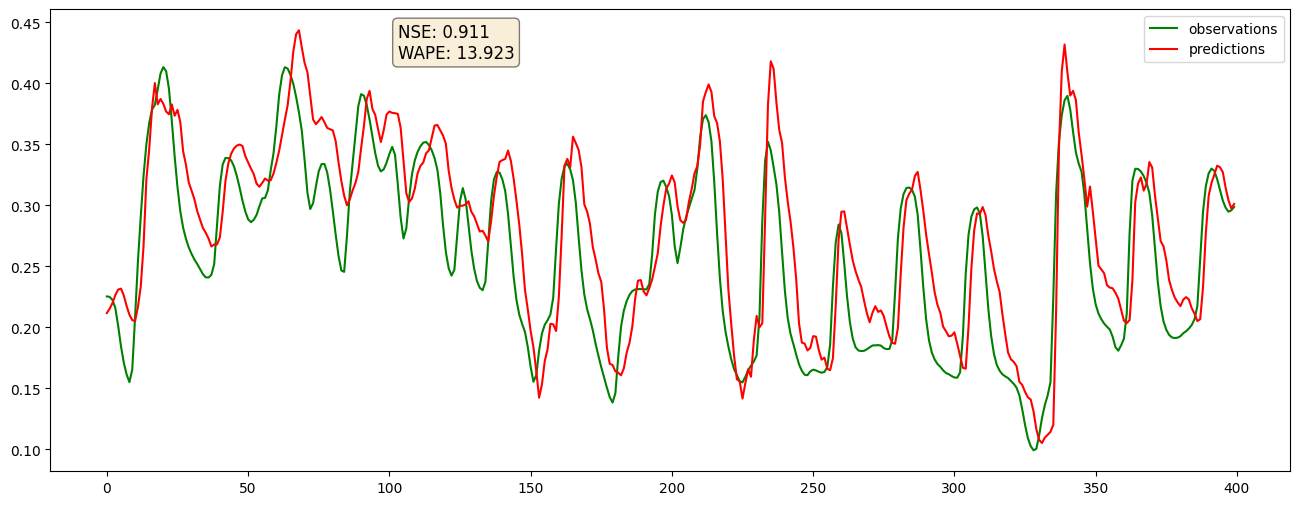

tensor(0.0010)

In [17]:
evaluate_model(model, test_loader, plot=True)

In [18]:
# Plot the results with the metrics inside it